## First look at the data

In [1]:
# this will make sure the root folder is the current working directory
from os import chdir, getcwd
from pyprojroot.here import here
chdir(here())
getcwd()

'/home/avila/devel/learn/ClearCutCostumerClustering'

In [2]:
# libs
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
# read data
df = pd.read_csv(
     "./data/01_input/Supermarket_customers.csv",
    delimiter="\t",              # note: \t because its a tab separated and not comma separated file
    parse_dates=["Dt_Customer"], # parse as dates
    date_format='%d-%m-%Y'
) 

# transform columns for sane column names
# thanks https://stackoverflow.com/a/74643649
df.columns = (df.columns
                .str.replace('(?<=[a-z])(?=[A-Z])', '_', regex=True)
                .str.lower()
             )

# remove absurd and yolo for now
df = df[~df["marital_status"].isin(["Absurd", "YOLO"])]

# replace alone -> single
df["marital_status"] = df["marital_status"].replace("Alone", "Single")

df.shape

(2236, 29)

In [4]:
def summarize_dataframe(df):
    # Container for all statistics
    all_stats = []

    for col in df.columns:
        col_data = df[col]
        num_missing = col_data.isna().sum()
        prop_missing = num_missing / len(col_data)

        if pd.api.types.is_datetime64_any_dtype(col_data):
            # Convert to numeric timestamps for calculations
            col_numeric = col_data.dropna().astype("int64")  # Dates as nanoseconds since epoch
            all_stats.append({
                "variable": col,
                "type": "datetime",
                "mean": pd.to_datetime(col_numeric.mean(), unit="ns") if not col_numeric.empty else None,
                "min": col_data.min(),
                "p05": col_data.quantile(0.05),
                "p50": col_data.median(),
                "p95": col_data.quantile(0.95),
                "max": col_data.max(),
                "num_missing": num_missing,
                "prop_missing": prop_missing
            })
        elif pd.api.types.is_numeric_dtype(col_data):
            all_stats.append({
                "variable": col,
                "type": "numeric",
                "mean": round(col_data.mean(), 4) if not col_data.empty else None,
                "min": col_data.min(),
                "p05": col_data.quantile(0.05),
                "p50": col_data.median(),
                "p95": col_data.quantile(0.95),
                "max": col_data.max(),
                "num_missing": num_missing,
                "prop_missing": prop_missing
            })
        elif isinstance(col_data.dtype, pd.CategoricalDtype) or col_data.dtype == "object":
            all_stats.append({
                "variable": col,
                "type": "categorical",
                "mean": None,
                "min": None,
                "p05": None,
                "p50": None,
                "p95": None,
                "max": None,
                "num_unique": col_data.nunique(),
                "num_missing": num_missing,
                "prop_missing": prop_missing
            })

    # Convert list of dictionaries to a DataFrame
    summary_df = pd.DataFrame(all_stats)
    return summary_df


In [5]:
s1  = summarize_dataframe(df)
s1

,variable,type,mean,min,p05,p50,p95,max,num_missing,prop_missing,num_unique
0,id,numeric,5591.5519,0,586.75,5458.5,10673.5,11191,0,0.000000,NaN
1,year_birth,numeric,1968.7965,1893,1950.0,1970.0,1988.0,1996,0,0.000000,NaN
2,education,categorical,None,None,None,None,None,None,0,0.000000,5.0
3,marital_status,categorical,None,None,None,None,None,None,0,0.000000,5.0
4,income,numeric,52232.5108,1730.0,18983.5,51381.5,84140.4,666666.0,24,0.010733,NaN
5,kidhome,numeric,0.445,0,0.0,0.0,1.0,2,0,0.000000,NaN
6,teenhome,numeric,0.5063,0,0.0,0.0,1.0,2,0,0.000000,NaN
7,dt_customer,datetime,2013-07-10 15:56:21.037566976,2012-07-30 00:00:00,2012-08-31 00:00:00,2013-07-09 00:00:00,2014-05-22 00:00:00,2014-06-29 00:00:00,0,0.000000,NaN
8,recency,numeric,49.1471,0,4.0,49.0,94.0,99,0,0.000000,NaN
9,mnt_wines,numeric,303.8734,0,3.0,173.0,1000.0,1493,0,0.000000,NaN


In [6]:
## regress income on regressors to estimate missing income

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# Define the list of predictor variables (with categorical columns included)
regressors = ["year_birth", "education", "marital_status", "kidhome", "teenhome",
              "recency", "mnt_wines", "mnt_fruits", "mnt_meat_products", "mnt_fish_products",
              "mnt_sweet_products", "mnt_gold_prods"]

# Separate rows with missing and non-missing income
df_missing = df[df["income"].isna()]
df_non_missing = df.dropna(subset=["income"])

# One-hot encode the categorical variables
df_non_missing_encoded = pd.get_dummies(df_non_missing[regressors], drop_first=True)
df_missing_encoded = pd.get_dummies(df_missing[regressors], drop_first=True)
df_all_obs_encoded = pd.get_dummies(df[regressors], drop_first=True)

# Ensure the training and missing data have the same columns (in case of mismatched categories)
df_non_missing_encoded, df_missing_encoded = df_non_missing_encoded.align(df_missing_encoded, join="left", axis=1, fill_value=0)

# Train a linear regression model on non-missing data
X_train = df_non_missing_encoded
y_train = df_non_missing["income"]
model = LinearRegression()
model.fit(X_train, y_train)

# Predict missing values
predicted_income = model.predict(df_missing_encoded)

# Impute the missing values in the original dataframe
# df.loc[df["income"].isna(), "income"] = predicted_income

# predict full (for comparison with available info)
predicted_income_full_df = model.predict(df_all_obs_encoded)
df["income_pred"] = predicted_income_full_df

df.to_csv("data/02_inter/tmp.csv")

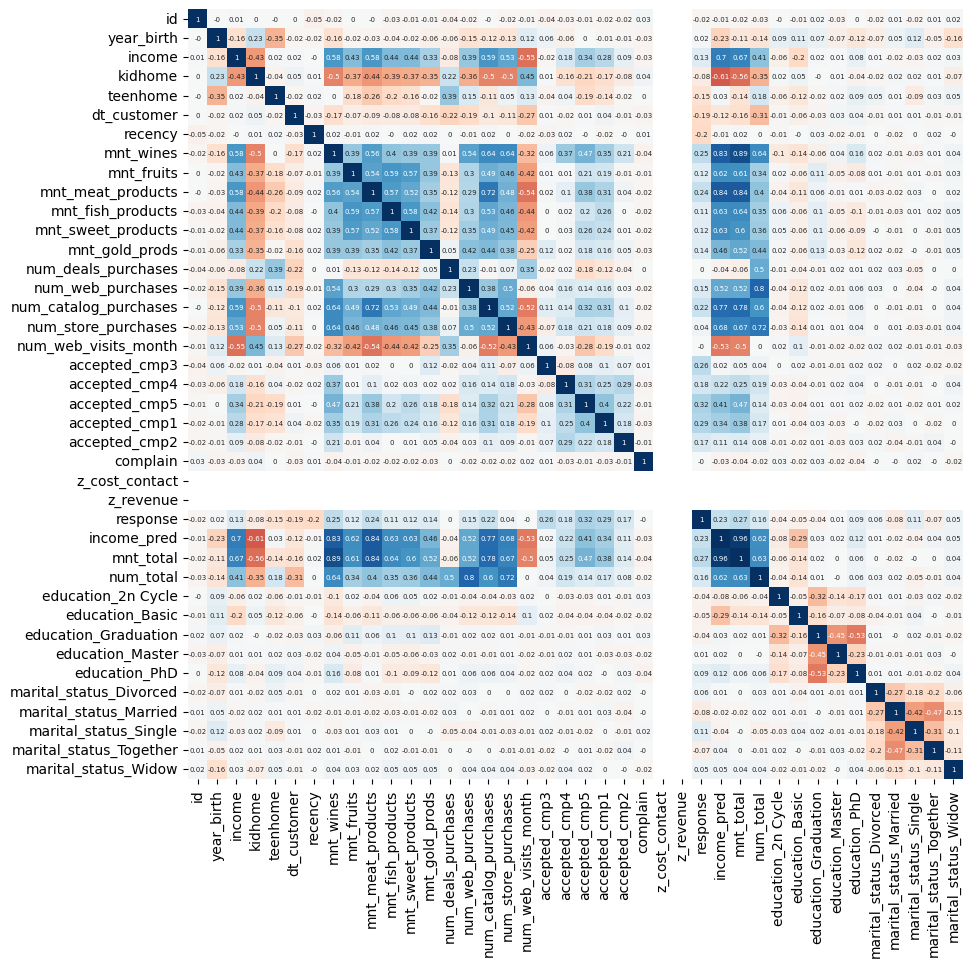

In [21]:
# get correlations 
df_full_encoded = pd.get_dummies(df, drop_first=False)
df_corr = df_full_encoded.corr()

# heatmap
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(
    round(df_corr,2), 
    cmap='RdBu',
    annot=True,
    annot_kws={"size": 5},
    vmin=-1, vmax=1,
    cbar=False
)

plt.show()

In [8]:
def summary_stats_by_group(df, group_var, target_var):
    
    # Calculate the summary statistics
    summary = df.groupby(group_var)[target_var].agg(
        count="count",  # Count the number of occurrences
        mean="mean",
        min="min",
        max="max",
        p01=lambda x: x.quantile(0.01),
        p05=lambda x: x.quantile(0.05),
        p10=lambda x: x.quantile(0.10),
        p25=lambda x: x.quantile(0.25),
        p50=lambda x: x.quantile(0.50),
        p75=lambda x: x.quantile(0.75),
        p90=lambda x: x.quantile(0.90),
        p95=lambda x: x.quantile(0.95),
        p99=lambda x: x.quantile(0.99)
    ).reset_index()

    # Sort by mean value (descending order)
    summary_sorted = summary.sort_values(by="mean", ascending=True)

    return summary_sorted

In [9]:
if "mnt_total" not in df.columns: df["mnt_total"] = df.filter(like="mnt").sum(axis=1)
if "num_total" not in df.columns: df["num_total"] = df.filter(like="num").sum(axis=1)

# if cond so that does not run more than once
df.filter(regex="mnt|num").head()

,mnt_wines,mnt_fruits,mnt_meat_products,mnt_fish_products,mnt_sweet_products,mnt_gold_prods,num_deals_purchases,num_web_purchases,num_catalog_purchases,num_store_purchases,num_web_visits_month,mnt_total,num_total
0,635,88,546,172,88,88,3,8,10,4,7,1617,32
1,11,1,6,2,1,6,2,1,1,2,5,27,11
2,426,49,127,111,21,42,1,8,2,10,4,776,25
3,11,4,20,10,3,5,2,2,0,4,6,53,14
4,173,43,118,46,27,15,5,5,3,6,5,422,24


In [10]:
# summary by education, target variable: income
summary_stats_by_group(df, group_var="education", target_var="income")

,education,count,mean,min,max,p01,p05,p10,p25,p50,p75,p90,p95,p99
1,Basic,54,20306.259259,7500.0,34445.0,7500.00,9335.20,13276.0,15405.25,20744.0,24882.00,27132.1,28298.00,32513.68
0,2n Cycle,200,47633.190000,7500.0,96547.0,7500.00,15289.05,20186.7,27526.50,46805.0,65393.25,78616.2,82354.85,89601.84
2,Graduation,1115,52696.585650,1730.0,666666.0,8199.78,19493.00,23964.6,34831.00,51983.0,69915.50,79848.2,83844.00,94384.00
3,Master,364,52883.002747,6560.0,157733.0,10979.00,22005.15,28976.7,37697.25,50920.5,66753.25,80018.9,84793.70,92420.52
4,PhD,479,56177.519833,4023.0,162397.0,15956.60,28370.20,32311.0,40397.50,55212.0,69190.50,81100.8,84921.60,104706.28


In [11]:
# summary by education, target variable: mnt_total
summary_stats_by_group(df, group_var="education", target_var="mnt_total")

,education,count,mean,min,max,p01,p05,p10,p25,p50,p75,p90,p95,p99
1,Basic,54,81.796296,14,839,15.06,18.00,24.0,29.75,57.0,80.00,103.0,169.4,624.35
0,2n Cycle,203,496.527094,13,2257,17.02,23.00,34.0,56.50,198.0,899.00,1289.0,1505.2,2048.02
3,Master,369,610.271003,10,2525,12.68,26.40,35.0,79.00,385.0,985.00,1616.2,1918.4,2282.08
2,Graduation,1126,619.369449,5,2524,14.25,22.00,35.0,70.00,414.0,1071.75,1535.5,1730.0,2147.25
4,PhD,484,673.435950,8,2440,10.00,20.15,39.0,88.00,494.0,1158.75,1655.6,1819.4,2114.85


In [12]:
# summary by education, target variable: income
summary_stats_by_group(df, group_var="education", target_var="num_total")

,education,count,mean,min,max,p01,p05,p10,p25,p50,p75,p90,p95,p99
1,Basic,54,13.888889,8,36,8.53,10.0,11.0,11.25,13.0,15.0,17.0,19.35,27.52
0,2n Cycle,203,19.256158,1,46,8.00,10.0,11.0,13.00,18.0,24.0,30.0,34.00,38.00
3,Master,369,20.108401,3,40,8.00,10.0,12.0,14.00,19.0,26.0,30.0,32.00,38.00
2,Graduation,1126,20.275311,0,44,9.00,10.0,12.0,14.00,20.0,25.0,30.0,33.00,38.00
4,PhD,484,21.064050,0,44,8.00,10.0,11.3,14.00,21.0,26.0,31.0,33.00,39.00


In [13]:
# summary by education, target variable: income
summary_stats_by_group(df, group_var="marital_status", target_var="income")

,marital_status,count,mean,min,max,p01,p05,p10,p25,p50,p75,p90,p95,p99
2,Single,474,50949.740506,3502.0,113734.0,7500.00,17817.25,22988.1,33725.75,48846.5,68655.00,81685.7,87540.10,95883.78
1,Married,857,51724.978996,2447.0,160803.0,7500.00,18772.40,23599.2,35441.00,51876.0,67546.00,79485.2,82520.00,92929.80
0,Divorced,232,52834.228448,1730.0,153924.0,9991.61,20410.80,25978.1,36948.00,52683.0,68758.50,79712.8,83738.25,90379.17
3,Together,573,53245.534031,5648.0,666666.0,12333.60,20465.40,24651.6,34916.00,51369.0,68682.00,78457.6,83844.00,98355.52
4,Widow,76,56481.552632,22123.0,85620.0,24549.25,28198.00,32465.5,44892.25,56551.0,70321.75,79113.5,82032.00,85119.75


In [14]:
# summary by education, target variable: mnt_total
summary_stats_by_group(df, group_var="marital_status", target_var="mnt_total")

,marital_status,count,mean,min,max,p01,p05,p10,p25,p50,p75,p90,p95,p99
1,Married,864,590.802083,8,2486,15.63,24.0,37.0,68.00,396.5,1001.00,1514.4,1726.55,2126.00
2,Single,483,604.310559,5,2525,15.00,22.0,29.4,70.50,354.0,1098.00,1566.4,1887.50,2131.10
3,Together,580,608.387931,8,2524,10.79,22.0,32.0,69.00,393.5,1039.25,1572.2,1804.60,2253.05
0,Divorced,232,610.629310,6,2074,8.93,20.0,31.0,61.25,395.0,1073.00,1476.5,1751.80,1885.87
4,Widow,77,738.818182,15,2088,21.08,32.0,44.0,138.00,636.0,1156.00,1564.4,1709.20,1967.92


In [15]:
# summary by education, target variable: num_total
summary_stats_by_group(df, group_var="marital_status", target_var="num_total")

,marital_status,count,mean,min,max,p01,p05,p10,p25,p50,p75,p90,p95,p99
2,Single,483,19.527950,7,38,8.00,10.0,11.0,14.0,19.0,24.0,29.0,31.00,35.18
3,Together,580,20.077586,1,46,8.00,10.0,11.0,14.0,19.0,26.0,30.0,32.00,38.00
1,Married,864,20.320602,0,44,9.00,11.0,12.0,14.0,20.0,26.0,30.7,34.00,38.37
0,Divorced,232,20.724138,0,39,8.00,10.0,11.0,14.0,20.0,28.0,31.0,34.45,38.00
4,Widow,77,21.584416,8,39,8.76,11.0,12.0,16.0,21.0,27.0,30.4,33.20,39.00


In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


def plot_violin_strip(df, group_var, target_var, figsize=(6,6), jitter=True, cut=0):
    # Create a figure for the plot
    plt.figure(figsize=figsize)

    # Create the violin plot (horizontal)
    ax = sns.violinplot(
        x=target_var, y=group_var, data=df, color="lightblue", cut=cut, split=True
    )
    ax.set(xlabel=None, ylabel=None)

    # Title and labels
    plt.title(f"Distribution of {target_var} \nby {group_var}", loc="left")

    # Show the plot
    plt.tight_layout()
    plt.show()

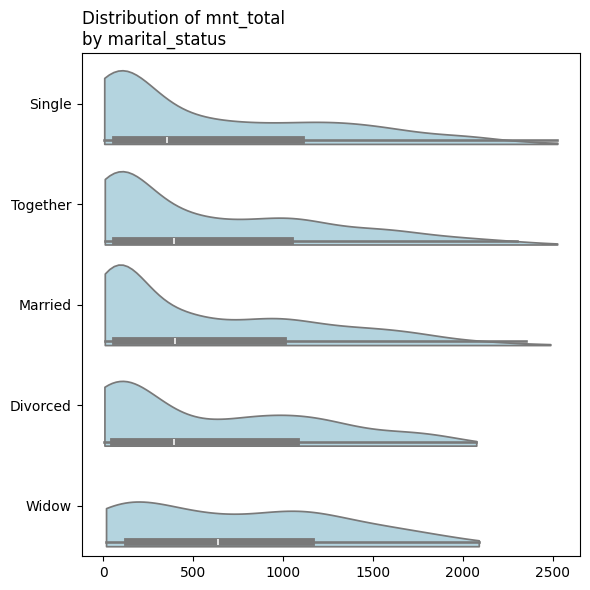

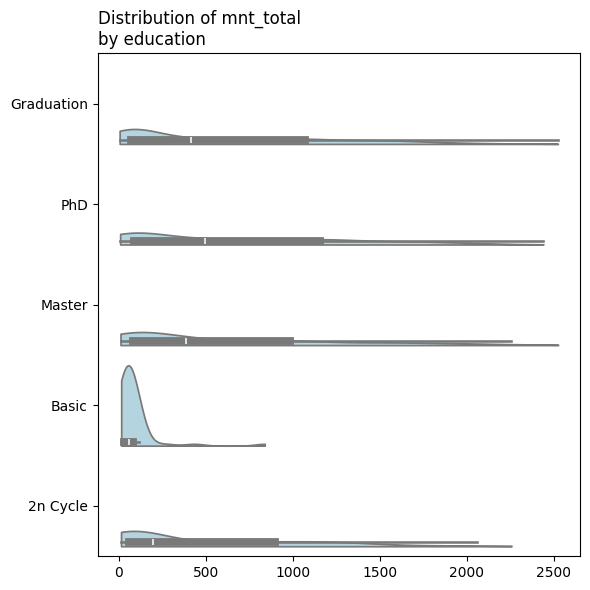

In [17]:
plot_violin_strip(df, group_var="marital_status", target_var="mnt_total")
plot_violin_strip(df, group_var="education", target_var="mnt_total")

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def visualize_selected_features(df, features, target_var=None, nrows=5, ncols=5, figsize=(20, 20)):
    """
    Visualizes selected features of a DataFrame grouped by a target variable.
    
    Parameters:
    - df (pd.DataFrame): The input dataset.
    - features (list): A list of feature names to visualize.
    - target_var (str): The column name of the target variable
    - nrows (int): Number of rows in the subplot grid. Default is 5.
    - ncols (int): Number of columns in the subplot grid. Default is 5.
    - figsize (tuple): Size of the overall figure. Default is (20, 20).
    """
    # Define the figure and axes for the grid of subplots
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = axes.flatten()
    

    
    # Loop over each feature and plot based on its type
    for i, feature in enumerate(features):
        if i >= len(axes):  # Skip plotting if axes are exhausted
            break
        
        if df[feature].dtype in ["float64", "int64"] and df[feature].max() > 5:  # Numerical features
            sns.histplot(data=df, x=feature, hue=target_var, kde=True, ax=axes[i])

        elif df[feature].dtype in ["category", "object"]:  # Nominal features
            sns.countplot(data=df, x=feature, hue=target_var, ax=axes[i])

        else:  # Ordinal or other types
            sns.violinplot(data=df, x=target_var, y=feature, ax=axes[i])
        
        # Set the title for the plot
        axes[i].set_title(feature)
        # axes[i].set_yscale("log")  
        axes[i].set(xlabel=None, ylabel=None)
    
    # Hide any remaining unused axes in the grid
    for j in range(len(features), len(axes)):
        fig.delaxes(axes[j])
    

    plt.tight_layout()
    plt.show()

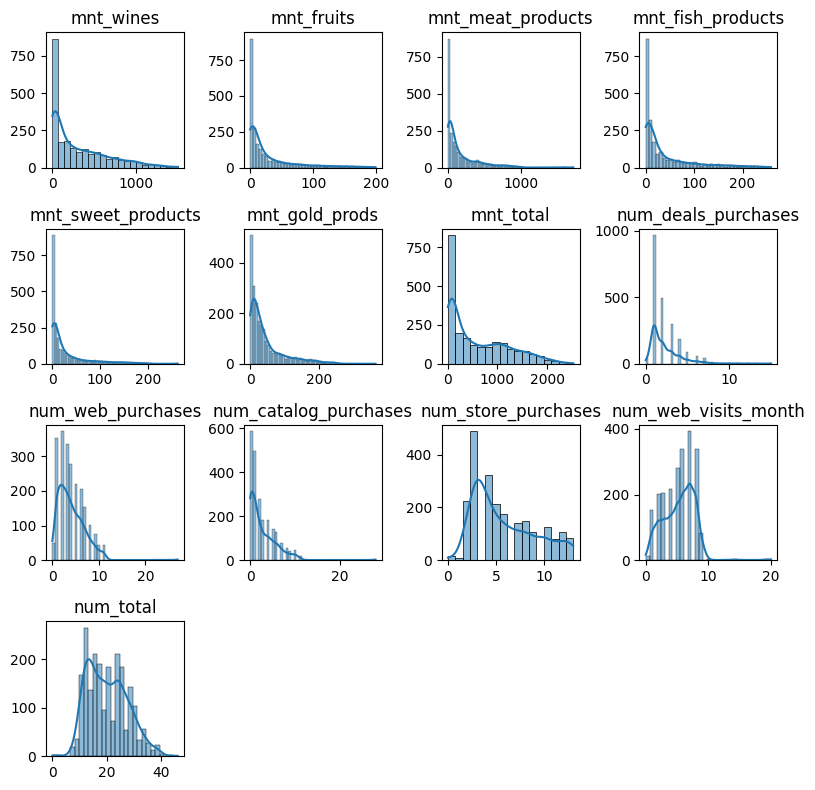

In [19]:
num_features = [
    "mnt_wines",
    "mnt_fruits",
    "mnt_meat_products",
    "mnt_fish_products",
    "mnt_sweet_products",
    "mnt_gold_prods",
    "mnt_total",
    "num_deals_purchases", 
    "num_web_purchases", 
    "num_catalog_purchases", 
    "num_store_purchases", 
    "num_web_visits_month",
    "num_total"
]

# Call the function for specific features
visualize_selected_features(
    df=df,
    features=num_features,
    nrows=4, 
    ncols=4, 
    figsize=(8,8)
)

In [20]:
df.to_parquet("data/02_inter/df_01_first_look.parquet")